# Affinity Propagation Clustering on Sport Activities

Le jeu de données est disponible ici : https://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities

In [75]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Code

In [2]:
import numpy as np
import time

Nous rajoutons au préalable un calcul de features (voir rapport) et le scaling des jeux de données de chaque CPU.

In [79]:
def features_computation(row,nb_series = 45,len_series = 125):
    features = np.empty([6 * nb_series +1])
    features[0] = row[0]
    for j in range(nb_series):
        ts = np.array(row[j*len_series+1:(j+1)*len_series+1])
        features[6*j+1:(j+1)*6+1] = np.array([np.min(ts),np.max(ts),np.mean(ts),np.median(ts),np.std(ts),compute_CE(ts,1,len_series)[0]])
    return(features)

def scaling(partition):
    """Scales the partition""" 
    partition_to_scale = partition[:,1:]
    #partition_to_scale = (partition_to_scale - np.mean(partition_to_scale, axis =0)) / np.std(partition_to_scale, axis =0)
    partition_to_scale = (partition_to_scale) / np.std(partition_to_scale, axis =0)
    u = partition[:,0]
    u = u.reshape(len(u),1)
    partition = np.concatenate((u,partition_to_scale), axis = 1)
    return(partition)

Le code ci-dessous est similaire à celui utilisé avec le jeu de données Iris : 

In [84]:
def euclidean_similarity(vector1,vector2):
    """Compute the Euclidean similarity (i.e : - Euclidean distance) between 2 vectors
    ----------------
    Parameter types:
    vector1: array
    vector2: array """

    return(-np.dot((vector1-vector2),(vector1-vector2).T))

def compute_CE(vector,nb_series = 45,len_series = 125):
    """ Compute the Complexity Estimate of the time series """
    CE = np.empty([nb_series])
    for i in range(nb_series):
        CE[i] = -euclidean_similarity(vector[i*len_series:(i+1)*len_series-1],vector[i*len_series+1:(i+1)*len_series]) #In order to avoid dividing by 0
    return(CE)

def complexity_invariant_distance(vector1,vector2,CE1 = 0, CE2 = 0,nb_series = 45,len_series = 125):
    """ Compute the Complexity Invariant Distance defined by Keogh"""
    if type(CE1) != "numpy.ndarray" :
        CE1 = compute_CE(vector1)
    if type(CE2) != "numpy.ndarray" :
        CE2 = compute_CE(vector2)
    sim = 0
    for i in range(nb_series):
        sim += euclidean_similarity(vector1[i*len_series:(i+1)*len_series],vector2[i*len_series:(i+1)*len_series])*max(CE1[i],CE2[i])/min(CE1[i],CE2[i])
    return(sim)

def parseLine(line, sep) :
    """ Parse the RDD
    ----------------
    Parameter types:
    line: string
    sep: string (ex: ',' or ';')"""
    parsed_line = line.split(sep)
    parsed_line =  [float(_) for _ in parsed_line]
    return(parsed_line)

def similarity_matrix_per_iterator(iterator, similarity_function, scaling = False):
    """ Compute the similarity matrix
    ----------------
    Parameter types:
    iterator: iterator from mapPartitions
    similarity_function: function (ex: euclidean_similarity)"""
    #Store partition in a list and reindex it
    partition = np.array(list(iterator))    
    nb_elements = len(partition)
    ind = range(nb_elements)
    #Normalisation
    if scaling == True:
        partition = scaling(partition)
        
    similarity_matrix = np.zeros([nb_elements, nb_elements])
    if (similarity_function == complexity_invariant_distance) :
        #Compute CE
        CE = list()
        for i in ind:
            CE.append(compute_CE(partition[i][1:]))        
    #Compute similarities
    for i in ind:
        for j in range(i+1,nb_elements):
            if (similarity_function == complexity_invariant_distance) :
                similarity_matrix[i,j] = similarity_function(partition[i][1:],partition[j][1:],CE1 = CE[i], CE2 = CE[j])
            else:
                similarity_matrix[i,j] = similarity_function(partition[i][1:],partition[j][1:])
            similarity_matrix[j,i] = similarity_matrix[i,j]
    return(nb_elements, ind, list(partition), similarity_matrix)

def add_preferences_to_similarity_matrix(similarity_matrix, preference_type ="median"):
    """ Update the preference value in the similarity matrix, i.e : updates the value of s(k,k)
    Several methods are available depending on the number of clusters expected by the user :
    -'median' : default method. Takes the median of the similarities as the preference value. 
    This method leads to a medium to large number of clusters
    -'minimum' : Takes the minimum preference value in the preference range (see article). This method leads to a small number of clusters.
    -'random' : Takes a random number in the preference range mentioned in the article as the preference value. 
    ----------------
    Parameter types:
    similarity_matrix: symetric numpy array
    preference_type: string (only "median" is available for the moment)"""
    if preference_type == "median":
        preference_value = np.median(similarity_matrix)
    if preference_type == "minimum":
        preference_value = np.min(similarity_matrix)
    np.fill_diagonal(similarity_matrix, preference_value)

def update_responsibility_and_availability(similarity_matrix, responsibility_matrix, availability_matrix, ind, lambda_damping):
    """ Update the responsibility matrix and the availability matrix 
    ----------------
    Parameter types:
    similarity_matrix: symetric numpy array
    responsibility_matrix: numpy array
    availability_matrix: numpy array
    ind: list or numpy vector (list of the "new" index, i.e : index on the partition and not globally in the dataset)
    lambda_damping: float between 0 and 1"""
    #1. Update Responsibility
    temp_sum_availability_similarity = np.add(availability_matrix, similarity_matrix) #compute a(i,k) + s(i,k) for all i,k
    argmax_resp = np.argmax(temp_sum_availability_similarity, axis = 1 ) #compute argmax { a(i,k') + s(i,k') } on ALL k' when i is fixed
    max_resp =  temp_sum_availability_similarity[ind,argmax_resp][:,None] #NB : [:,None] converts the row of max values into a column
    #Compute the new r(i,k) when k is not equal to argmax { a(i,k') + s(i,k') }
    temp_responsibility_matrix = np.subtract(similarity_matrix,max_resp) 
    #Compute the new r(i,k) when k is equal to  argmax { a(i,k') + s(i,k') } :
    temp_sum_availability_similarity[ind,argmax_resp] = -np.inf #Set the (i,k)th element to -inf when k is an argmax for row i
    max_resp2 = np.max(temp_sum_availability_similarity, axis = 1) #compute new max for row i (the real max value of the row being set to -inf here)
    temp_responsibility_matrix[ind,argmax_resp] = similarity_matrix[ind,argmax_resp] - max_resp2
    #Damping
    responsibility_matrix = (1 - lambda_damping) * temp_responsibility_matrix + lambda_damping*responsibility_matrix
    #Remove temporary variables
    del temp_sum_availability_similarity
    del temp_responsibility_matrix
    
    #2. Update Availability for i != k
    temp_matrix = np.maximum(0, responsibility_matrix)
    temp_matrix = np.sum(temp_matrix, axis = 0) - temp_matrix #Compute el(i,k) = sum(max(0,r(i',k)) - max(0, r(i,k))
    temp_matrix_diag = temp_matrix.diagonal() #Store the updated a(k,k) values
    temp_matrix = np.minimum(0, responsibility_matrix.diagonal()) + temp_matrix
    temp_matrix = np.minimum(0, temp_matrix)

    #3. Update Availability for i ==k
    np.fill_diagonal(temp_matrix, temp_matrix_diag) #set the diagonal values to the updated a(k,k) values computed above
    
    #Damping
    availability_matrix = (1 - lambda_damping) * temp_matrix + lambda_damping*availability_matrix
    return(responsibility_matrix, availability_matrix)

def center_decision(responsibility_matrix, availability_matrix):
    """ Find the center chosen by each individual 
    (using the "new" index, i.e: the index on the partition and not the global index of the dataset)
    ----------------
    Parameter types:
    responsibility_matrix: numpy array
    availability_matrix: numpy array"""
    temp_matrix = responsibility_matrix + availability_matrix
    decision = np.argmax(temp_matrix, axis = 1)
    return(decision)

def affinity_propagation_clustering_per_partition(iterator, similarity_function = euclidean_similarity , preference_type ="median", 
                                                  lambda_damping = 0.5, max_iter = 200, max_unchange_count = 3, scaling = False):
    """
    Terminal conditions : max_iter or unchanged decisions for some number of iterations
    We need to add the terminal condition (2) of the article"""
    #1. Compute similarity matrix
    nb_elements, ind, partition, similarity_matrix = similarity_matrix_per_iterator(iterator, similarity_function, scaling = scaling)
    #2. Compute preferences
    add_preferences_to_similarity_matrix(similarity_matrix, preference_type)
    #3. Initialize
    responsibility_matrix = np.zeros([nb_elements, nb_elements]) 
    availability_matrix = np.zeros([nb_elements, nb_elements])
    decision = ind
    unchange_count = 0
    #4. Update responsibility and availability until one of the terminal conditions is met
    for it in range(max_iter) :
        responsibility_matrix, availability_matrix = update_responsibility_and_availability(similarity_matrix, responsibility_matrix, 
                                                                                            availability_matrix, ind, lambda_damping)
        temp_decision = center_decision(responsibility_matrix, availability_matrix)
        if np.array_equal(temp_decision, decision) : 
            unchange_count = unchange_count + 1
            if unchange_count >=  max_unchange_count :
                decision = temp_decision
                break
        else: 
            decision = temp_decision
    #5. Aggregate points with the same centers and add the center coordinates (using the initial index)
    decision = sorted(zip(decision, ind), key = lambda x : x[0])
    from itertools import groupby
    output = list()
    for key, group in groupby(decision, lambda x: x[0]):
        output.append((partition[key][0], [partition[j][0] for i,j in group], partition[key][1:], similarity_matrix[0,0]))
    return(output)

In [81]:
def getRoots3(aNeigh):
    """ Connected Components Research in a Graph
    ----------------
    Parameter types:
    aNeigh: graph repesented by a dictionnary with key = node and value = list of connected nodes """
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
            (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
            if myRoot_myI != myRoot_myJ: 
                myMin = myRoot_myI
                myMax = myRoot_myJ 
                if  myDepthMyI > myDepthMyJ: 
                    myMin = myRoot_myJ
                    myMax = myRoot_myI
                myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                myRoot[myMin] = (myRoot[myMax][0],-1) 
    myToRet = {}
    for myI in aNeigh: 
        myToRet[myI] = findRoot(myI,myRoot)[0]
    return myToRet  

In [85]:
def affinity_propagation_clustering_sport(name_file, sep = ',', cluster_aggregation_parameter = 0.5, similarity_function = euclidean_similarity,
                                   preference_type ="median", lambda_damping = 0.5, max_iter = 200, max_unchange_count = 3,
                                   aggregation = 'master', scaling = False):
    """ Create an RDD from a text file and return the Affinity Propagation Clustering result 
    ----------------
    Parameter types:
    name_file: string (path to text file) """
    rdd = sc.textFile(name_file)
    rdd = rdd.map(lambda line : parseLine(line, sep))
    # Create Features
    rdd_features = rdd.map(lambda row : features_computation(row,nb_series = 45,len_series = 125))
    #1. Affinity Propagation Clustering on each partition
    rdd2 = rdd.mapPartitions(lambda iterator : affinity_propagation_clustering_per_partition(iterator, 
                                                                                             similarity_function = similarity_function , 
                                                                                             preference_type = preference_type, 
                                                                                             lambda_damping = lambda_damping, 
                                                                                             max_iter = max_iter, 
                                                                                             max_unchange_count = max_unchange_count,
                                                                                             scaling = scaling), 
                         preservesPartitioning=True)
    if aggregation == 'master' :
        result = rdd2.collect()
        dico = {}
        for center1 in result :
            for center2 in result :
                if similarity_function(center1[2], center2[2]) > cluster_aggregation_parameter*((center1[3] + center2[3])/2) :
                    if center1[0] in dico:
                        dico[center1[0]].append(center2[0])
                    else:
                        dico[center1[0]] = list([center2[0]])
    else :
        #2. Compute similarities between all centers
        rdd_dist = rdd2.cartesian(rdd2).map(lambda u : ((u[0][0], u[1][0]),euclidean_similarity(u[0][2], u[1][2]),
                                                        cluster_aggregation_parameter*((u[0][3] + u[1][3])/2)))
        #3. Filter centers which are close to each other (the threshold depends on the preference values and the cluster_aggregation_parameter)
        edges = rdd_dist.filter(lambda u : u[1] > u[2]).map(lambda u: u[0])
        #4. Format the selected centers as the nodes of a graph where there is an edge is their similarity was higher than the threshold
        edges = edges.map(lambda nameTuple: (nameTuple[0], [ nameTuple[1] ])) \
        .reduceByKey(lambda a, b: a + b)  # combine lists: ([1,2,3] + [4,5]) becomes [1,2,3,4,5]
        # 5. Collect results on the master CPU
        dico = dict(edges.collect())
    
    #6. Find the connected components on the graph (centers that need to be aggregated in one center)
    connected_components = getRoots3(dico)
    #7. Broadcast the results from the master to the workers
    connected_components_broadcast = sc.broadcast(connected_components)
    #8. Assign the new centers to the Affinity Propagation Clustering on each partition results
    rdd3 = rdd2.map(lambda x : (connected_components_broadcast.value[x[0]], x[1]))
    #9. Aggregate the lists of points that belong to the same cluster (same center = same key)
    result_clustering = rdd3.reduceByKey(lambda a, b: a + b)
    return(result_clustering)

## Préparation des données

In [47]:
import random

In [48]:
def index_dataset(in_filename, out_filename, out_filename_label, sep = ','):   
    with open(out_filename, 'w') as output_file:
        with open(out_filename_label, 'w') as output_file_label:
            with open(in_filename, 'r') as input_file :
                lines = list(input_file)
                random.seed( 3 )
                random.shuffle(lines)
                for i,line in enumerate(lines) :
                    without_label = line.split(',')
                    output_line = str(i) +',' + ','.join(without_label[3:len(without_label)])
                    output_label = str(i) +','+ ','.join(without_label[:3]) + '\n'
                    output_file.write(output_line)
                    output_file_label.write(output_label)          

In [49]:
index_dataset("data_sport_bis.txt", "indexed_sport.txt","indexed_sport_label.txt", sep = ',')

In [50]:
rdd = sc.textFile("indexed_sport.txt")

Regardons en combien de partitions (nombre de CPU) les données sont réparties :

In [51]:
rdd.getNumPartitions()

13

## Clustering

Nous avons regroupé toutes les étapes précédentes au sein de la fonction affinity_propagation_clustering. Testons là en utilisant le paramétrage recommandé par l'article, à savoir une valeur de préférence égale à la médiane et un cluster_aggregation_parameter égal à 0.5.

In [78]:
start_time = time.time()
result_clustering = affinity_propagation_clustering_sport("indexed_sport.txt", cluster_aggregation_parameter = 0.04, 
                                                    similarity_function = euclidean_similarity,
                                                    preference_type ="minimum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 85.4420001507 seconds ---


## Visualisation des résultats

In [86]:
import pandas as pd
df_res = pd.DataFrame(result_clustering.flatMap(lambda x : [(point, x[0]) for point in x[1]]).collect())
df_res.columns=['Id', 'Cluster']
df_res.head()

,Id,Cluster
0,40.0,548.0
1,65.0,548.0
2,98.0,548.0
3,109.0,548.0
4,121.0,548.0


In [87]:
data_df = pd.read_csv("indexed_sport.txt", header = None)
title =np.array(np.char.mod("%d",range(45*125+1)))
title[0]="Id"
data_df.columns = title
data_df.head()

,Id,1,2,3,4,5,6,7,8,9,...,5616,5617,5618,5619,5620,5621,5622,5623,5624,5625
0,0,5.6199,-0.027411,0.009516,-1.241500,-0.04581,0.23984,-0.85378,0.17532,-0.494490,...,0.338920,-30.1560,-1.07150,-2.87610,-0.67634,1.26030,-0.24906,1.197200,0.38167,-0.120480
1,1,9.6619,-0.766020,0.543600,0.060168,0.13573,-0.36530,-0.66470,-0.26463,0.165660,...,-0.095905,-9.4919,-1.23750,-7.05600,-4.26390,-1.59470,0.33855,0.467340,-0.28754,-0.077930
2,2,9.2316,0.493050,5.057200,1.310600,-0.14318,0.33626,-0.72886,-0.22858,-0.500990,...,-0.186000,-7.7652,0.21266,-0.39082,-0.56939,-0.19958,1.52590,0.360800,0.48221,-0.000944
3,3,8.1747,0.878630,5.172000,0.165940,-0.12952,-0.12150,-0.78045,-0.10761,0.004967,...,-0.168900,8.6125,2.84050,2.11800,-0.41733,-0.54667,0.99320,0.059269,0.55865,0.223690
4,4,8.6966,0.526600,5.956500,0.515980,-0.23421,-0.15076,-0.90412,0.31644,-0.135050,...,0.129390,-9.6392,-8.97280,-6.31830,-0.71058,-0.70095,1.69840,0.686880,0.46264,-0.059072


In [88]:
label_df = pd.read_csv("indexed_sport_label.txt", header = None)
label_df.columns = ["Id","Activity","Person","Segment"]
label_df.head()

,Id,Activity,Person,Segment
0,0,a12,p3,s43
1,1,a08,p7,s05
2,2,a14,p1,s41
3,3,a15,p7,s45
4,4,a16,p4,s32


In [89]:
final_df = pd.merge(data_df, df_res, left_on = "Id", right_on = "Id")
final_df = pd.merge(final_df, label_df, left_on = "Id", right_on = "Id")
final_df.head()

,Id,1,2,3,4,5,6,7,8,9,...,5620,5621,5622,5623,5624,5625,Cluster,Activity,Person,Segment
0,0,5.6199,-0.027411,0.009516,-1.241500,-0.04581,0.23984,-0.85378,0.17532,-0.494490,...,-0.67634,1.26030,-0.24906,1.197200,0.38167,-0.120480,186.0,a12,p3,s43
1,1,9.6619,-0.766020,0.543600,0.060168,0.13573,-0.36530,-0.66470,-0.26463,0.165660,...,-4.26390,-1.59470,0.33855,0.467340,-0.28754,-0.077930,186.0,a08,p7,s05
2,2,9.2316,0.493050,5.057200,1.310600,-0.14318,0.33626,-0.72886,-0.22858,-0.500990,...,-0.56939,-0.19958,1.52590,0.360800,0.48221,-0.000944,186.0,a14,p1,s41
3,3,8.1747,0.878630,5.172000,0.165940,-0.12952,-0.12150,-0.78045,-0.10761,0.004967,...,-0.41733,-0.54667,0.99320,0.059269,0.55865,0.223690,49.0,a15,p7,s45
4,4,8.6966,0.526600,5.956500,0.515980,-0.23421,-0.15076,-0.90412,0.31644,-0.135050,...,-0.71058,-0.70095,1.69840,0.686880,0.46264,-0.059072,49.0,a16,p4,s32


### Répartition des activités au sein des clusters

In [90]:
groups = final_df.groupby('Cluster')
for name, group in groups:
    print(name)
    data = list(group["Activity"])
    uniques = set(data)
    freqs = [(activity, data.count(activity)) for activity in uniques]
    print(freqs)

49.0
[('a15', 480), ('a17', 480), ('a16', 463), ('a03', 477), ('a01', 479), ('a19', 1), ('a08', 1), ('a04', 10)]
186.0
[('a14', 480), ('a08', 478), ('a09', 480), ('a11', 480), ('a10', 480), ('a13', 480), ('a12', 475), ('a02', 480), ('a19', 479), ('a01', 1), ('a06', 480), ('a18', 480), ('a05', 480), ('a16', 17), ('a07', 480)]
548.0
[('a03', 3), ('a08', 1), ('a04', 422)]
816.0
[('a04', 35)]
7588.0
[('a04', 13)]
7789.0
[('a12', 5)]


### Visualisation

In [91]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

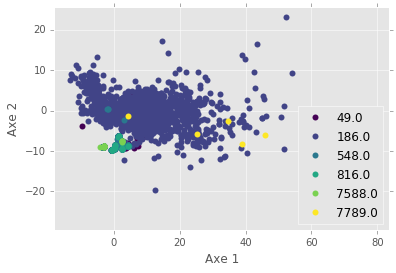

In [95]:
groups = final_df.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['1'], group['2'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='lower right')
ax.set_xlabel('Axe 1')
ax.set_ylabel('Axe 2')

plt.show()